In [1]:
import torch
import torch.nn as nn
import numpy as np
from PIL import Image
import os
encoding = '2345678bcdefgmnpwxy'

class Captcha(torch.utils.data.Dataset):
    def __init__(self, transform):
        self.img_list = []
        self.transform = transform
        for root, dirs, files in os.walk('samples'):
            if root == 'samples':
                self.img_list.extend(files)
        
    def __getitem__(self, index):
        prefix = 'samples/'
        img = Image.open(prefix+self.img_list[index])
        label = []
        for j in range(5):
            label.append(encoding.index(self.img_list[index][j]))
        return {
            'img_raw': self.transform[0](img),
            'img': self.transform[1](img),
        }
    def __len__(self):
        return len(self.img_list)
from torchvision import transforms
transform = transforms.Compose([
                transforms.Resize((56, 224)),
                transforms.Grayscale(),
                transforms.Pad((0, 84, 0, 84)),
                transforms.ToTensor()])
raw = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor()])
dataset = Captcha((raw, transform))

In [2]:
import torchvision.models as models
class CaptchaSolver(nn.Module):
    def __init__(self):
        super(CaptchaSolver, self).__init__()
        self.resnet = models.resnet50(pretrained=False)
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.fc0 = nn.Linear(1000, len(encoding))
        self.fc1 = nn.Linear(1000, len(encoding))
        self.fc2 = nn.Linear(1000, len(encoding))
        self.fc3 = nn.Linear(1000, len(encoding))
        self.fc4 = nn.Linear(1000, len(encoding))
    def forward(self, x):
        x = self.resnet(x)
        out = []
        out.append(self.fc0(x))
        out.append(self.fc1(x))
        out.append(self.fc2(x))
        out.append(self.fc3(x))
        out.append(self.fc4(x))
        return out
captchaSolver = CaptchaSolver().cuda()
captchaSolver.load_state_dict(torch.load('captcha_solver_params.pth'))

<All keys matched successfully>

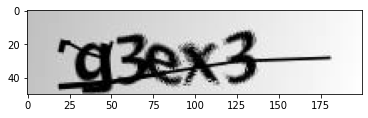

Label: g3ex3


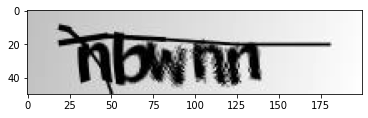

Label: nbwnn


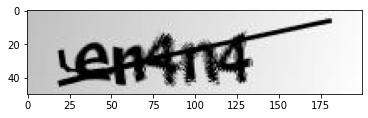

Label: en4n4


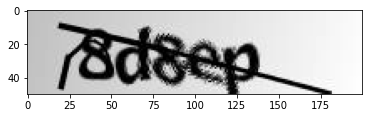

Label: 8d8ep


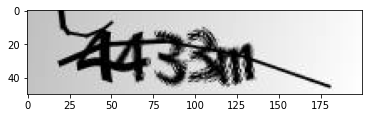

Label: 4433m


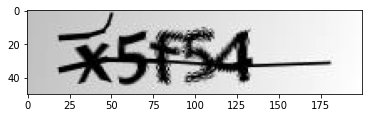

Label: xff54


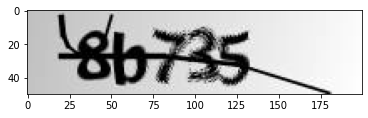

Label: 8b735


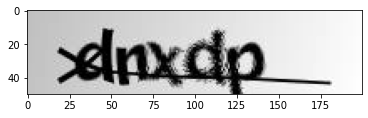

Label: dnxdp


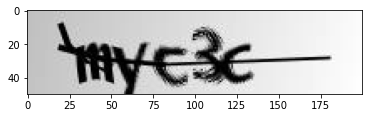

Label: myc3c


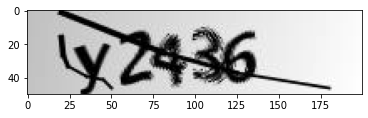

Label: y2436


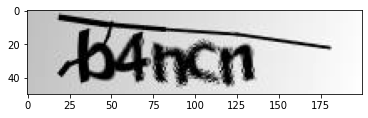

Label: b4ncn


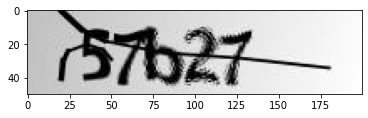

Label: 57b27


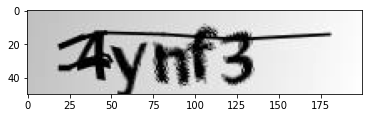

Label: 4ynf3


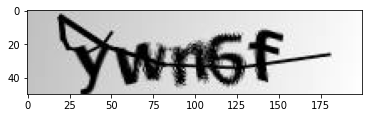

Label: ywn6f


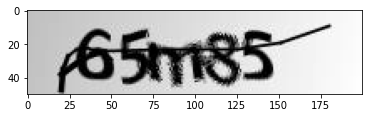

Label: 65m85


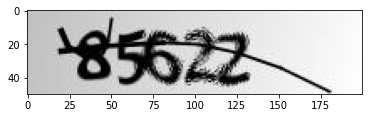

Label: 85622


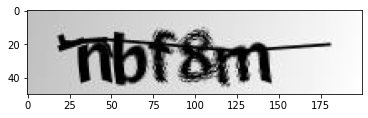

Label: nbf8m


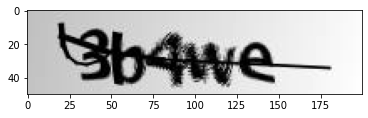

Label: 5b4we


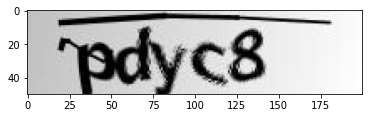

Label: pdyc8


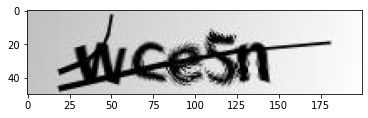

Label: wce5n


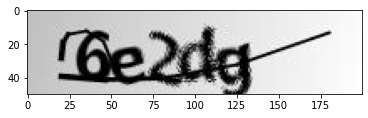

Label: 6e2dg


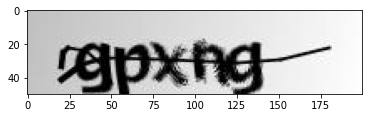

Label: gpxng


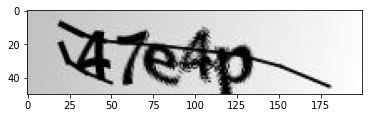

Label: 47e4p


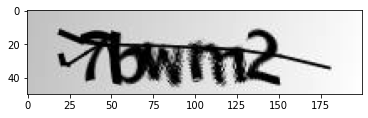

Label: 7bwm2


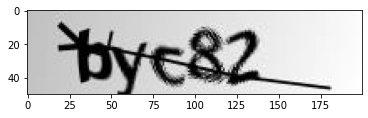

Label: byc82


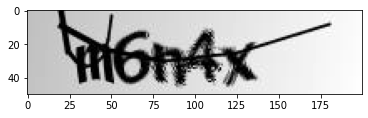

Label: m6n4x


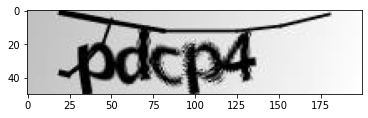

Label: pdcp4


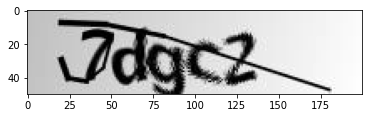

Label: 7dgc2


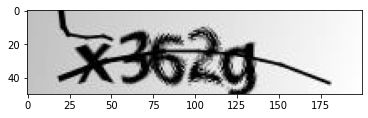

Label: x362g


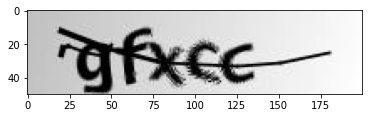

Label: gfxcc


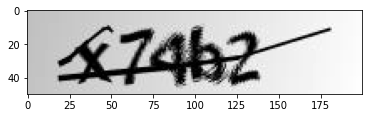

Label: x74b2


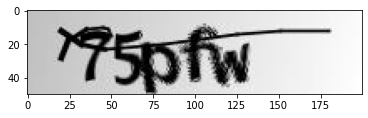

Label: 75pfm


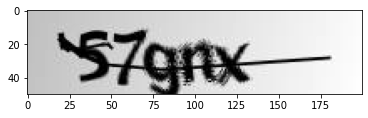

Label: 57gnx


In [3]:
from torch.utils.data import DataLoader
test_loader = DataLoader(dataset, batch_size=32, shuffle=True)

import matplotlib.pyplot as plt
import random
with torch.no_grad():
    for data in test_loader:
        index = random.randrange(32)
        img = data['img'].cuda()
        out = captchaSolver(img)
        pred_label = None
        for i in range(5):
            _, pred = torch.max(out[i], 1)
            if pred_label is None:
                pred_label = pred.view(-1, 1)
            else:
                pred_label = torch.cat((pred_label, pred.view(-1, 1)), 1)
        try:
            plt.imshow(data['img_raw'][index].permute(1, 2, 0), cmap='gray')
            plt.show()
            print('Label: ', end='')
            for l in pred_label[index]:
                print(encoding[int(l.item())], end='')
            print()
        except IndexError:
            pass